In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv('heart_disease.csv')

In [5]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis,target
0,63,1,1,145.0,233.0,1,2,150,0,2.3,3,1.0,6.0,0,0
1,67,1,4,160.0,286.0,0,2,108,1,1.5,2,3.0,3.0,2,1
2,67,1,4,120.0,229.0,0,2,129,1,2.6,2,2.0,7.0,1,1
3,37,1,3,130.0,250.0,0,0,187,0,3.5,3,1.0,3.0,0,0
4,41,0,2,130.0,204.0,0,2,172,0,1.4,1,1.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110.0,264.0,0,0,132,0,1.2,2,1.0,7.0,1,1
299,68,1,4,144.0,193.0,1,0,141,0,3.4,2,2.0,7.0,2,1
300,57,1,4,130.0,131.0,0,0,115,1,1.2,2,1.0,7.0,3,1
301,57,0,2,130.0,236.0,0,2,174,0,0.0,2,1.0,3.0,1,1


In [11]:
df.columns

Index(['age', ' sex', ' cp', ' trestbps', ' chol', ' fbs', ' restecg',
       ' thalach', ' exang', ' oldpeak', ' slope', ' ca', ' thal',
       ' diagnosis', 'target'],
      dtype='object')

In [13]:
df.columns = [col.strip() for col in df.columns]

In [61]:
X_full = df.drop(['target','diagnosis'], axis=1)
y = df['diagnosis']

categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
X_encoded_full = pd.get_dummies(X_full, columns=categorical_cols)

In [65]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_encoded_full, y)

importances = pd.Series(rf.feature_importances_, index=X_encoded_full.columns)
top_features = importances.sort_values(ascending=False).head(5).index.tolist()
print("Top features for Clustering:", top_features)

X_top = X_encoded_full[top_features]

# Scaling
scaler_top = StandardScaler()
X_top_scaled = scaler_top.fit_transform(X_top)

Top features for Clustering: ['thalach', 'oldpeak', 'chol', 'age', 'trestbps']


In [69]:
pca_top = PCA(n_components=2)
X_top_pca = pca_top.fit_transform(X_top_scaled)

C:\Users\ELOott\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ELOott\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ELOott\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ELOott\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Wi

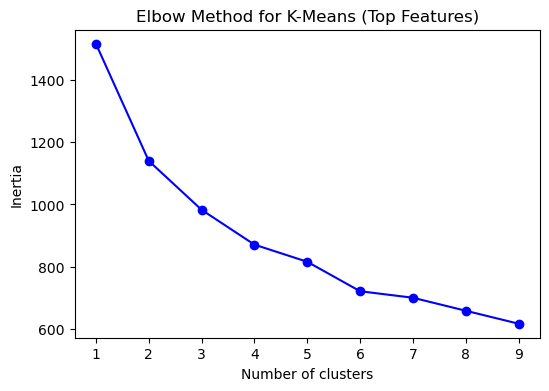

In [71]:
inertia = []
K_range = range(1, 10)
for k in K_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(X_top_scaled)
    inertia.append(kmeans_test.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means (Top Features)')
plt.show()

In [75]:
kmeans_top = KMeans(n_clusters=6, random_state=42)
kmeans_top_labels = kmeans_top.fit_predict(X_top_pca)

ari_kmeans_top = adjusted_rand_score(y, kmeans_top_labels)
sil_kmeans_top = silhouette_score(X_top_pca, kmeans_top_labels)
print(f"K-Means (Top Features) ARI: {ari_kmeans_top:.3f}, Silhouette: {sil_kmeans_top:.3f}")

K-Means (Top Features) ARI: 0.058, Silhouette: 0.346


C:\Users\ELOott\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [77]:
linked = linkage(X_top_pca, method='ward')
hier_labels = fcluster(linked, 2, criterion='maxclust')

ari_hier = adjusted_rand_score(y, hier_labels)
sil_hier = silhouette_score(X_top_pca, hier_labels)
print(f"Hierarchical (PCA) ARI: {ari_hier:.3f}, Silhouette: {sil_hier:.3f}")

Hierarchical (PCA) ARI: 0.121, Silhouette: 0.369


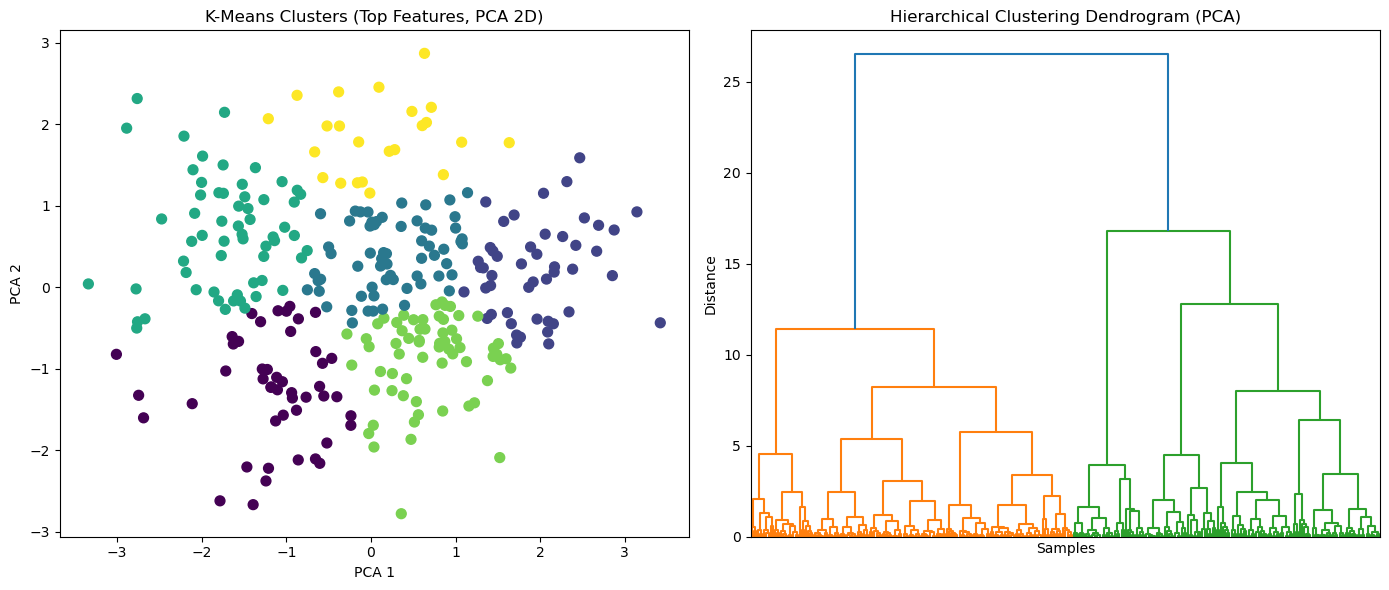

In [79]:
plt.figure(figsize=(14,6))

# K-Means
plt.subplot(1,2,1)
plt.scatter(X_top_pca[:,0], X_top_pca[:,1], c=kmeans_top_labels, cmap='viridis', s=50)
plt.title('K-Means Clusters (Top Features, PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# Hierarchical dendrogram
plt.subplot(1,2,2)
dendrogram(linked, no_labels=True, color_threshold=None)
plt.title('Hierarchical Clustering Dendrogram (PCA)')
plt.xlabel('Samples')
plt.ylabel('Distance')

plt.tight_layout()
plt.show()